In [2]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #to avoid killing kernel !! 

#work tomorrow on 3 qubit case and 1 qubit case

In [1]:
import pennylane as qml
#import numpy as np
from pennylane import numpy as np
#import tensorflow as tf
import qutip as qt
from matplotlib import pyplot as plt

We also declare a 3-qubit simulator device running in Cirq.


In [26]:
dev = qml.device('default.qubit', wires=3)

Generator and Discriminator
===========================




In [27]:
def U1(w,wire):
    qml.RZ(w[0],wires = wire)
    qml.RX(w[1],wires = wire)
    qml.RZ(w[2],wires = wire)

def U2(w,wire1,wire2):
    U1(w[0:3], wire1)
    U1(w[3:6], wire2)
    qml.CNOT(wires = [wire2,wire1])
    qml.RZ(w[6],wires = wire1)
    qml.RY(w[7],wires = wire2)
    qml.CNOT(wires = [wire1,wire2])
    qml.RY(w[8],wires = wire2)
    qml.CNOT(wires = [wire2,wire1])
    U1(w[9:12], wire1)
    U1(w[12:15],wire2)

In [28]:
def real(w):
    U2(w,0,1)
    

def generator(w, **kwargs):
    U2(w[0:15],0,1)
    #U2(w[15:30],0,1) #Erase this, be careful with overparametrization
    
def discriminator(w, **kwargs):
    U2(w[0:15],0,1)
    U2(w[15:30],1,2)
    U2(w[30:45],0,1)
    U2(w[45:60],1,2)

# Nodes

In [29]:
@qml.qnode(dev, diff_method="parameter-shift")
def real_disc_circuit(real_params, disc_weights):
    real(real_params)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

@qml.gradients.param_shift
@qml.qnode(dev)
def real_disc_circuit_gradient(disc_weights):
    real(real_params)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))


@qml.qnode(dev, diff_method="parameter-shift")
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

@qml.gradients.param_shift
@qml.qnode(dev)
def gen_disc_circuit_gradient_disc(disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

@qml.gradients.param_shift
@qml.qnode(dev)
def gen_disc_circuit_gradient_gen(gen_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

QGAN cost functions
===================




In [30]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(real_params, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights):
    cost = -prob_fake_true(gen_weights, disc_weights)
    return cost



Initializing the weights
=================


Real state generation

In [31]:
real_params = np.random.uniform(low=-np.pi, high=np.pi, size=15)

Generator and Discriminator parameter initialization

In [32]:
init_gen_weights = np.random.uniform(low=-np.pi, high=np.pi, size=30)

init_disc_weights = np.random.uniform(low=-np.pi, high=np.pi, size=60)

#gen_weights = tf.Variable(init_gen_weights)
#disc_weights = tf.Variable(init_disc_weights)
gen_weights=np.array(list(init_gen_weights), requires_grad=False)
disc_weights=np.array(list(init_disc_weights), requires_grad=True)


We begin by creating the optimizer:


In [33]:
#opt = tf.keras.optimizers.Adam(learning_rate = 0.05) #in another simulation they use 0.1 #AMSgrad = True
#opt  = qml.ShotAdaptiveOptimizer(min_shots=10)
#opt=qml.AdamOptimizer(stepsize=0.5)
opt1=qml.GradientDescentOptimizer(stepsize=0.05)
opt2=qml.GradientDescentOptimizer(stepsize=0.05)

We train in turns. We expect around 250 turns to converge. Each turn consists of 5 discriminator steps and 1 generator step.

# Define some other metrics

In [34]:
dev_state = qml.device('default.qubit', wires=2)

In [35]:
@qml.qnode(dev_state)
def real_circuit(w):
    U1(w[0:3], 0)
    U1(w[3:6], 1)
    qml.CNOT(wires = [1,0])
    qml.RZ(w[6],wires = 0)
    qml.RY(w[7],wires = 1)
    qml.CNOT(wires = [0,1])
    qml.RY(w[8],wires = 1)
    qml.CNOT(wires = [1,0])
    U1(w[9:12], 0)
    U1(w[12:15],1)
    return qml.state()


@qml.qnode(dev_state)
def gen_circuit(gen_weights):
    generator(gen_weights)
    return qml.state()

In [36]:
def fidelity(real_params,gen_weights):
    real_state = qt.Qobj(real_circuit(real_params).numpy())
    gen_state = qt.Qobj(gen_circuit(gen_weights).numpy())
    
    ρ_R = real_state * real_state.dag()
    ρ_G = gen_state * gen_state.dag()
    
    F = qt.fidelity(ρ_R,ρ_G)
    return F

In [37]:
def trace_distance(real_params,gen_weights):
    real_state = qt.Qobj(real_circuit(real_params).numpy())
    gen_state = qt.Qobj(gen_circuit(gen_weights).numpy())
    
    ρ_R = real_state * real_state.dag()
    ρ_G = gen_state * gen_state.dag()
    
    d = qt.tracedist(ρ_R,ρ_G)
    return d

------------------------------------------------------------------------------

# Training routine

In [38]:
#----- Metrics ----------------------------

Disc_cost = [] # P(R|R)-P(R|G)
Gen_cost = [] # P(R|G)
Trace_d = [] #Trace distance
F = [] #Fidelity

#-------------------------------------------

costD = lambda: disc_cost(disc_weights)
costG = lambda: gen_cost(gen_weights)

#print("gen_weights", gen_weights)
#print("disc_weights", disc_weights)


for turn in range(250):
    print("Begin "+ str(turn) + " discriminator optimization")
    disc_weights=np.array(list(disc_weights), requires_grad=True)
    gen_weights=np.array(list(gen_weights), requires_grad=False)
    for step in range(5): #The actual ratio should be 20 to 1, according to what we discussed
        #opt.minimize(costD, disc_weights)
        print("Before "+str(step) + " disc gradient computation of "+str(turn)+ " round of optimization")
        #grad_fn_disc=real_disc_circuit_gradient(disc_weights)-gen_disc_circuit_gradient_disc(disc_weights)
        grad_gen_circuit_disc=qml.grad(gen_disc_circuit, argnum=1)
        grad_real_disc_circuit=qml.grad(real_disc_circuit, argnum=1) 
        grad_fn_disc=grad_gen_circuit_disc(gen_weights, disc_weights)-grad_real_disc_circuit(real_params, disc_weights)
        #print("grad_fn_disc", grad_fn_disc)
        print("After"+str(step) + " disc gradient computation of "+str(turn)+ " round of optimization")
        disc_weights=np.array(opt1.apply_grad(grad_fn_disc, disc_weights), requires_grad=True)
        #disc_weights=np.array(opt1.step(disc_cost, disc_weights), requires_grad=True)
        #print("disc_weights", disc_weights)
        print("After"+str(step) + " disc opt update of "+str(turn)+ " round of optimization")

        if step == 4:
            costD_val = costD().numpy()
            print("Step {}: cost = {}".format(step, costD_val))
            Disc_cost += [-costD_val] # P(R|R)-P(R|G)
    print("End of " + str(turn)+" discriminator optimization")    
    print("end of "+ str(turn)+ " optimization ")
            #opt.minimize(costG, gen_weights)
    disc_weights=np.array(list(disc_weights), requires_grad=False)
    gen_weights=np.array(list(gen_weights), requires_grad=True)
    print("Begin of "+str(turn)+" generator optimization")
    #print("gen_weights", gen_weights)
    #print("disc_weights", disc_weights)
    disc_weights=np.array(list(disc_weights), requires_grad=False)
    gen_weights=np.array(list(gen_weights), requires_grad=True)

    print("Before gen gradient computation")
    #grad_fn_gen=-gen_disc_circuit_gradient_gen(gen_weights)
    grad_fn_gen=-qml.grad(gen_disc_circuit, argnum=0)(gen_weights, disc_weights)
    #print("grad_fn_gen", grad_fn_gen)
    print("After gen gradient computation")
    gen_weights=np.array(opt2.apply_grad(grad_fn_gen, gen_weights), requires_grad=True)
    #gen_weights=np.array(opt2.step(gen_cost, gen_weights), requires_grad=True)
   # print("gen_weights", gen_weights)
    #print("disc_weights", disc_weights)
    print("After gen opt update ")
    costG_val = costG().numpy()
    #print("Step {}: cost = {}".format(step, costG_val))
    Gen_cost += [-costG_val] # P(R|G)
    
 

    print("computation of fidelity")
    fid = fidelity(real_params,gen_weights)

    F += [fid] #Fidelity
    print("end of fidelity")
    print("computation of trace distance")
    TrD = trace_distance(real_params,gen_weights)
    print("end of computation of trace distance")
    Trace_d += [TrD] #Trace distance
    
    print("P(R|R)-P(R|G): ", -costD_val)
    print("P(R|G): ", -costG_val)
    print("Fidelity: ",fid)
    print("Trace distance: ",TrD)
    print("------------------------------")
    

Begin 0 discriminator optimization
Before 0 disc gradient computation of 0 round of optimization
After0 disc gradient computation of 0 round of optimization
After0 disc opt update of 0 round of optimization
Before 1 disc gradient computation of 0 round of optimization
After1 disc gradient computation of 0 round of optimization
After1 disc opt update of 0 round of optimization
Before 2 disc gradient computation of 0 round of optimization
After2 disc gradient computation of 0 round of optimization
After2 disc opt update of 0 round of optimization
Before 3 disc gradient computation of 0 round of optimization
After3 disc gradient computation of 0 round of optimization
After3 disc opt update of 0 round of optimization
Before 4 disc gradient computation of 0 round of optimization
After4 disc gradient computation of 0 round of optimization
After4 disc opt update of 0 round of optimization
Step 4: cost = -0.33822306220420895
End of 0 discriminator optimization
end of 0 optimization 
Begin of 0

In [ ]:
F = np.array(F)
Gen_cost = np.array(Gen_cost)
Disc_cost = np.array(Disc_cost)
Trace_d = np.array(Trace_d)

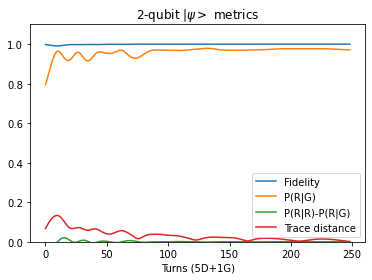

In [25]:
plt.plot(F, label='Fidelity')
plt.plot(Gen_cost, label='P(R|G)')
plt.plot(Disc_cost, label='P(R|R)-P(R|G)')
plt.plot(Trace_d, label='Trace distance')
plt.ylim([0,1.1])
plt.xlabel('Turns (5D+1G)') 
plt.title("2-qubit $|\psi>$ metrics")
plt.legend()
plt.savefig('2qubitlearning_250_runs_1_G_layer.png', format='png')
plt.savefig('2qubitlearning_250_runs_1_G_layer.pdf')

In [54]:
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

bloch_vector_real = qml.map(real, obs, dev, interface="tf")
bloch_vector_generator = qml.map(generator, obs, dev, interface="tf")

print("Real Bloch vector: {}".format(bloch_vector_real([phi, theta, omega])))
print("Generator Bloch vector: {}".format(bloch_vector_generator(gen_weights)))

AttributeError: type object 'h5py.h5.H5PYConfig' has no attribute '__reduce_cython__'